# Efficient screening calculation for large interface systems 
**by <span style="color:darkgreen">Maximilian Schebek</span> for [<span style="color:DarkGoldenRod">exciting *fluorine*</span>](http://exciting.wikidot.com/fluorine)**

<hr style="border:2px solid #DDD"> </hr>

**<span style="color:firebrick">Purpose</span>**: In this tutorial you will learn how efficiently compute dielectric screening for large interface systems within many-body perturbation theory following the approach presented in [**Xuan et al., J. Chem. Theory Comput. 2019, 15, 3824−3835**](https://pubs.acs.org/doi/full/10.1021/acs.jctc.9b00229). As an example, this effect will be studied for benzene on a supercell of Molybdenum disulfide (MoS2). Note that this is an advanced tutorial - make sure to be familiar with the basics of BSE as explained e.g. in the tutorials [**Excited states from BSE**](../tutorial_excited_states_from_bse/tutorial_excited_states_from_bse.ipynb) and [**Exciton Analysis and Visualization**](http://exciting.wikidot.com/oxygen-exciton-visualization) (not yet available as notebook).

**<span style="color:red">NOTE:</span>** Due to the large number of atoms, this tutorial **<span style="color:red">cannot</span>** be run on a simple PC, you will need to have access to a cluster. This tutorial is only meant as a guide how to prepare  the input files and as a presentation of the workflow.

<hr style="border:2px solid #DDD"> </hr>

<div class="alert alert-block alert-warning">
    
**Table of Contents**
   
[1. Theoretical background: Dielectric screening in interfaces](#1)
    
[2. Preliminary Step: Dielectric matrices of the individual systems](#2)
    
[3. BSE calculation of the the interface system](#3)
  

</div>

<a id='1'></a>
<hr style="border:1px solid #DDD"> </hr>



### <span style="color:#15317E">1. Dielectric screening in interfaces</span>
<details>

<summary><strong><span style="color:firebrick"> Click to show theoretical background!</span></strong></summary>

Before starting with the calculation, we briefly review the theoretical background. Within the **<em>GW</em>** and **BSE** frameworks, methods stemming from many-body perturbation theory, the dielectric screening of the bare Coulomb potential $v$ is described by the dielectric function $\varepsilon$. In a plane-wave basis, the dielectric function is expressed in terms of its Fourier coefficients  $\varepsilon_{\mathbf{G}\mathbf{G}'}(\mathbf{q})$ which can be obtained through the Fourier coefficients of the polarizability, $\chi{\mathbf{G}\mathbf{G}'}(\mathbf{q})$, according to

$$
\varepsilon_{\mathbf{G}\mathbf{G}'}(\mathbf{q}) = \delta_{\mathbf{G}\mathbf{G}'} - v_{\mathbf{G}}(\mathbf{q})\chi_{\mathbf{G}\mathbf{G}'}(\mathbf{q}).
$$

The computation of the dielectric matrix, or equivalently, the polarizability, is one of the computational bottlenecks in  **<em>GW</em>** and **BSE** calculations with a computational cost scaling as $\mathcal{O}(N^4)$. The simulation of large bilayer interface systems, consisting of two monolayer systems (denoted as systems $(1)$ and $(2)$), therefore often becomes prohibitively expensive. An elegant way of circumventing is given by assuming the additivity of the polarizability, i.e.

$$
\chi_{\mathbf{G}\mathbf{G}'}(\mathbf{q}) = \chi^{(1)}_{\mathbf{G}\mathbf{G}'}(\mathbf{q}) + \chi^{(2)}_{\mathbf{G}\mathbf{G}'}(\mathbf{q}).
$$

Here, the polarizability of the bilayer interface system, $\chi_{\mathbf{G}\mathbf{G}'}(\mathbf{q})$, can be expressed in terms of the polarziabilities of the individual systems $\chi^{(1)}_{\mathbf{G}\mathbf{G}'}(\mathbf{q})$  and $ \chi^{(2)}_{\mathbf{G}\mathbf{G}'}(\mathbf{q})$. Now, the special structure of bilayer systems can be exploited: The two monolayers building the interface system typically are supercells of individual sub-unitcells, i.e. a $n_1 \times m_1$ supercell of the first individual sub-unitcell on top of a $n_2 \times m_2$ supercell of the second individual sub-unitcell (as an example, in this tutorial we will consider consider a benzene molecule on top of a $3 \times 3$ supercell of ${\rm MoS}_2$). Due to the fact that it we can compute the polarizability of the two systems individually, it is possible to obtain the polarizability of the individual supercells from the a calculation of the corresponding sub-unitcell: Due to the periodic boundary conditions, the amount of information obtained from a supercell calculation is equivalent to that obtained from the unit-cell. We therefore simply have to compute the following mapping:

$$
\chi^{(i), {\rm subunit}}_{\mathbf{G}\mathbf{G}'}(\mathbf{q}) \rightarrow \chi^{(i)}_{\mathbf{G}\mathbf{G}'}(\mathbf{q}).
$$

If you are interested in the details of this mapping, you are encouraged to have a look into the paper linked in the tutorial description.
</details>


<a id='2'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">2. Preliminary Step: Dielectric matrices of the individual systems</span>


**<span style="color:firebrick">Important note:</span>** All input parameters are given in **atomic units!**

In this tutorial we consider as an example a benzene molecule on top of a $3 \times 3$ supercell of ${\rm MoS}_2$. First, we create a **run** directory where will run all our calculations.

```bash
$ mkdir run
$ cd run
```

Inside the directory **run** we create three subdirectories: **interface_system**, **benzene**, and **mos2** where we perform the calculations of the different systems.

```bash
$ mkdir interface benzene mos2
```

As a first step, we create the input files for the individual systems, the ${\rm MoS}_2$ unit cell and the benzene molecule in a cell with a volume corresponding to a $3 \times 3$ supercell of the ${\rm MoS}_2$ unit cell. First, let's move to the mos2 directory and have a look at the ${\rm MoS}_2$ input file.

```bash
$ cd mos2
```

```xml

<input>

  <title> MoS2 unit cell  </title>

  <structure speciespath="$EXCITINGROOT/species " tshift="false">

      <crystal>
         <basevect>   5.97625562 0.00000000 0.000000000</basevect>
         <basevect>  -2.98812782 5.17558919 0.000000000</basevect>
         <basevect>   0.00000000 0.00000000 40.40868137</basevect>
      </crystal>

      <species speciesfile="Mo.xml" rmt="2.2">
         <atom coord="0.33333333 0.66666667 0.43069139"/>
      </species>
      
      <species speciesfile="S.xml" rmt="2.2">
         <atom coord="0.66666667 0.33333333 0.35742493"/>
         <atom coord="0.66666667 0.33333333 0.50395736"/>
      </species>
  
   </structure>

   <groundstate 
       do="fromscratch" 
       tforce="true" 
       rgkmax="8.55555" 
       gmaxvr="22" 
       ngridk="9 9 1" 
       xctype="GGA_PBE" 
       nempty="20" 
       maxscl="500" 
       mixer="msec" 
       vdWcorrection="TSvdW">
   </groundstate>
   
   <xs 
      xstype="BSE" 
      ngridk="9 9 1" 
      vkloff="0.0 0.0 0.0"
      ngridq="9 9 1"
      nempty="20"
      gqmax="1.0"
      reduceq="true">

      <energywindow 
         intv="0.0 0.5" 
         points="2400"/>

      <screening 
         screentype="full"
         nempty="60"/>

      <BSE
         bsetype="singlet"
         nstlbse="10 13 1 4"
         distribute="true" />
         
      <qpointset>
         <qpoint>0.0 0.0 0.0</qpoint>
      </qpointset>

      <plan>
         <doonly task="scrgeneigvec"/>
         <doonly task="scrwritepmat"/>
         <doonly task="screen"/>
         <doonly task="write_dielectric_matrix"/>
      </plan>
      
   </xs>

</input>

```

With this input, we will first run a groundstate calculation followed by the calculation of the dielectric matrix. The meaning of these attributes are explained in [**Excited states from BSE**](../tutorial_excited_states_from_bse/tutorial_excited_states_from_bse.ipynb).

The second step, computing the dielectric matrix, is a central part of every **BSE** calculation. However, as we are not interested in running a full **BSE** calculation, we can run only the specific steps needed for this purpose by specifying them in the  **plan** element. We added the task **write_dielectric_matrix** which will write the dielectric matrix (which was only computed for the symmetry-reduced **q**-vectors) for all **q**-vectors. This step is important for the XAF method to work correctly. Now you can copy the input into the new file **input.xml** and run the calculation. The resulting dielectric matrix will be stored in the folder **EPS0**.


Next, we will repeat these steps, i.e. a groundstate calculation and the subsequent calculation of the dielectric matrix, for the benzene molecule. First, move to the benzene directory:

```bash
$ cd ../
$ cd benzene
```

The input looks like the following:

```xml
<input>

  <title> Benzene in 3 x 3 x 1 MoS2 supercell</title>

  <structure speciespath="$EXCITINGROOT/species " tshift="false">

    <crystal>
      <basevect>   17.928766881       0.0000000       0.000000000</basevect>
      <basevect>  -8.9643834405   15.526767578       0.000000000</basevect>
      <basevect>   0.000000       0.0000000       40.408681362</basevect>
    </crystal>

    <species speciesfile="C.xml" rmt="1.15000">
      <atom coord="0.35955395 0.64044662 0.65594474"/>
      <atom coord="0.52933551 0.72533769 0.65594474"/>
      <atom coord="0.61422601 0.64044662 0.65594474"/>
      <atom coord="0.52933494 0.47066449 0.65594474"/>
      <atom coord="0.35955338 0.38577342 0.65594474"/>
      <atom coord="0.27466288 0.47066449 0.65594474"/>
    </species>
    <species speciesfile="H.xml" rmt="0.9000">
      <atom coord="0.29321989 0.70677728 0.65594474"/>
      <atom coord="0.59566617 0.857999   0.65594474"/>
      <atom coord="0.74689072 0.70677728 0.65594474"/>
      <atom coord="0.595669   0.40433383 0.65594474"/>
      <atom coord="0.29322272 0.25311211 0.65594474"/>
      <atom coord="0.14199817 0.40433383 0.65594474"/>
    </species>
  </structure>

  <groundstate 
       do="fromscratch" 
       tforce="true" 
       rgkmax="3.5"
       gmaxvr="22" 
       ngridk="3 3 1" 
       xctype="GGA_PBE" 
       nempty="20" 
       maxscl="500" 
       mixer="msec" 
       vdWcorrection="TSvdW">
  </groundstate>

  <xs 
      xstype="BSE" 
      ngridk="3 3 1" 
      vkloff="0.0 0.0 0.0"
      ngridq="3 3 1"
      nempty="100"
      gqmax="1.0"
      broad="0.0018"
      scissor="0.03373661"
      tappinfo="true"
      reduceq="true"
      tevout="true"
      dfoffdiag="true">

      <energywindow 
         intv="0.0 0.5" 
         points="2400"/>

      <screening 
         screentype="full"
         nempty="539"/>

    <BSE
        bsetype="singlet"
        nstlbse="37 40 1 4"
        distribute="true" 
                  />

    <qpointset>
        <qpoint>0.0 0.0 0.0</qpoint>
    </qpointset>


    <plan>
        <doonly task="scrgeneigvec"/>
        <doonly task="scrwritepmat"/>
        <doonly task="screen"/>
        <doonly task="write_dielectric_matrix"/>
    </plan>   


  </xs>
</input>
```

The lattice vectors now correspond to the ones of a $3 \times 3$ supercell of the ${\rm MoS}_2$ unit cell. Note that due to the small hydrogen muffin-tin radius we used a smaller value of **rgkmax** compared to the ${\rm MoS}_2$ case. This ensures that the same $\mathbf{|G+k|}_{\rm max}$ cutoff is used for both systems.

Now you can copy the input into the new file **input.xml**.


### <span style="color:#15317E">3. BSE calculation of the interface system</span>

Now it is time to run a full **BSE** calculation for the interface system. 

```bash
$ cd ../
$ cd interface
```

To make use of the additive XAF approach, we need to copy the dielectric matrices (stored in **EPS0**) of the two individual components as well as the used **q**-grids (stored in **QPOINTS_SCR.OUT**)  and **q+G**-grids (stored in **GQPOINTS**)  into the **interface** directory. We can copy and simultaneously rename the various directories with the following commands:

```bash
$ cp -r ../mos2/EPS0 EPS0_1
$ cp -r ../mos2/GQPOINTS GQPOINTS_1 
$ cp ../mos2/QPOINTS_SCR.OUT QPOINTS_SCR_1.OUT

$ cp -r ../benzene/EPS0 EPS0_2
$ cp -r ../benzene/GQPOINTS GQPOINTS_2
$ cp  ../benzene/QPOINTS_SCR.OUT QPOINTS_SCR_2.OUT

```

Doing so, ${\rm MoS}_2$ is considered as system $(1)$ of the interface system and benzene as system $(2)$. Of course, this choice is arbitrary and we could have done it the other way round. It is, however, important to be consistent with this naming in the following input file when specifying the supercell dimensions of the two systems in the attributes **supercell_1** and **supercell_2**.

The input file for the full interface is given in the following:

```xml

<input>

  <title> Benzene on MoS2 supercell. </title>

  <structure speciespath="$EXCITINGROOT/species " tshift="false">

    <crystal>
      <basevect>   17.928766881       0.0000000       0.000000000</basevect>
      <basevect>  -8.9643834405   15.526767578       0.000000000</basevect>
      <basevect>   0.000000       0.0000000       40.408681362</basevect>
    </crystal>

    <species speciesfile="Mo.xml" rmt="2.2">
      <atom coord="0.11111111   0.22222222  0.43069139"/>
      <atom coord="0.11111111190434297 0.5555555555961248 0.4306913918"/>
      <atom coord="0.11111111238680436 0.8888888890511657 0.4306913918751582"/>
      <atom coord="0.44444444496601865 0.2222222221410838 0.4306913918751582"/>
      <atom coord="0.4444444454484801 0.5555555555961248 0.4306913918751582"/>
      <atom coord="0.44444444593094146 0.8888888890511657 0.430691391917247"/>
      <atom coord="0.7777777785101557 0.2222222221410838 0.4306913918751582"/>
      <atom coord="0.7777777789926172 0.5555555555961248 0.4306913918751582"/>
      <atom coord="0.7777777794750785 0.8888888890511657 0.4306913918751582"/>
    </species>

    <species speciesfile="S.xml" rmt="2.2">
      <atom coord="0.22222222227220556 0.1111111110705419  0.35742493435609096"/>
      <atom coord="0.22222222227220556 0.1111111110705419  0.5039573593401586"/>
      <atom coord="0.22222222275466696 0.44444444452558285 0.35742493435609096"/>
      <atom coord="0.22222222275466696 0.44444444452558285 0.5039573593401586"/>
      <atom coord="0.22222222323712837 0.7777777779806239  0.35742493435609096"/>
      <atom coord="0.22222222323712837 0.7777777779806239  0.5039573593401586"/>
      <atom coord="0.5555555558163426  0.1111111110705419  0.35742493435609096"/>
      <atom coord="0.5555555558163426  0.1111111110705419  0.5039573593401586"/>
      <atom coord="0.555555556298804   0.44444444452558285 0.35742493435609096"/>
      <atom coord="0.555555556298804   0.44444444452558285 0.5039573593401586"/>
      <atom coord="0.5555555567812654  0.7777777779806239  0.35742493435609096"/>
      <atom coord="0.5555555567812654  0.7777777779806239  0.5039573593401586"/>
      <atom coord="0.8888888893604797  0.1111111110705419  0.35742493435609096"/>
      <atom coord="0.8888888893604797  0.1111111110705419  0.5039573593401586"/>
      <atom coord="0.8888888898429411  0.44444444452558285 0.35742493435609096"/>
      <atom coord="0.8888888898429411  0.44444444452558285 0.5039573593401586"/>
      <atom coord="0.8888888903254026  0.7777777779806239  0.35742493435609096"/>
      <atom coord="0.8888888903254026  0.7777777779806239  0.5039573593401586"/>
    </species>

    <species speciesfile="C.xml" rmt="1.15000">
      <atom coord="0.35955395 0.64044662  0.65594474"/>
      <atom coord="0.52933551 0.72533769 0.65594474"/>
      <atom coord="0.61422601 0.64044662 0.65594474"/>
      <atom coord="0.52933494 0.47066449  0.65594474"/>
      <atom coord="0.35955338 0.38577342  0.65594474"/>
      <atom coord="0.27466288 0.47066449  0.65594474"/>
    </species>

    <species speciesfile="H.xml" rmt="0.9000">
      <atom coord="0.29321989 0.70677728  0.65594474"/>
      <atom coord="0.59566617 0.857999  0.65594474"/>
      <atom coord="0.74689072 0.70677728  0.65594474"/>
      <atom coord="0.595669   0.40433383  0.65594474"/>
      <atom coord="0.29322272 0.25311211  0.65594474"/>
      <atom coord="0.14199817 0.40433383  0.65594474"/>
    </species>

  </structure>

  <groundstate 
       do="fromscratch" 
       rgkmax="3.5" 
       gmaxvr="22" 
       ngridk="3 3 1" 
       xctype="GGA_PBE" 
       nempty="20" 
       maxscl="500" 
       mixer="msec" 
       vdWcorrection="TSvdW">
  </groundstate>

  <xs 
    xstype="BSE" 
    ngridk="3 3 1" 
    vkloff="0.0 0.0 0.0"
    ngridq="3 3 1"
    nempty="100"
    gqmax="1.0"
    broad="0.0018"
    scissor="0.03373661"
    tappinfo="true"
    tevout="true"
    reduceq="false"      
    dfoffdiag="true">

    <energywindow 
        intv="0.0 0.5" 
        points="2400"/>

    <screening 
        screentype="full"
        nempty="539"/>

    <expand_eps
        supercell_1="3 3 1"
        supercell_2="1 1 1"/>

    <BSE
        bsetype="singlet"
        nstlbse="97 132 1 36"
        distribute="true" 
        />

    <qpointset>
        <qpoint>0.0 0.0 0.0</qpoint>
    </qpointset>

    <plan>
      <doonly task="xsgeneigvec"/>
      <doonly task="writepmatxs"/>

      <doonly task="expand_add_eps"/>

      <doonly task="scrcoulint"/>
      <doonly task="exccoulint"/>
      <doonly task="bse"/>
    </plan>
  
  </xs>

</input>
```
To replace the standard screening calculation needed in the **BSE** by the additive approach we include the task **expand_add_eps**. This requires further the presence of the **expand_eps** element. Here, we have to specify the dimensions of the supercells of the sub-unit cells that are used in the interface.  In our case, this is $3 \times 3 \times 1$ for ${\rm MoS}_2$ and $1 \times 1 \times 1$ for benzene as this molecule was already computed in the $3 \times 3 \times 1$ supercell of ${\rm MoS}_2$. 

In the following figure, you see the optical spectrum obtained with the XAF approach. As a reference, the spectrum obtained using the exact screening is also shown. As you can see, the two spectra are almost identical with some very subtle changes.

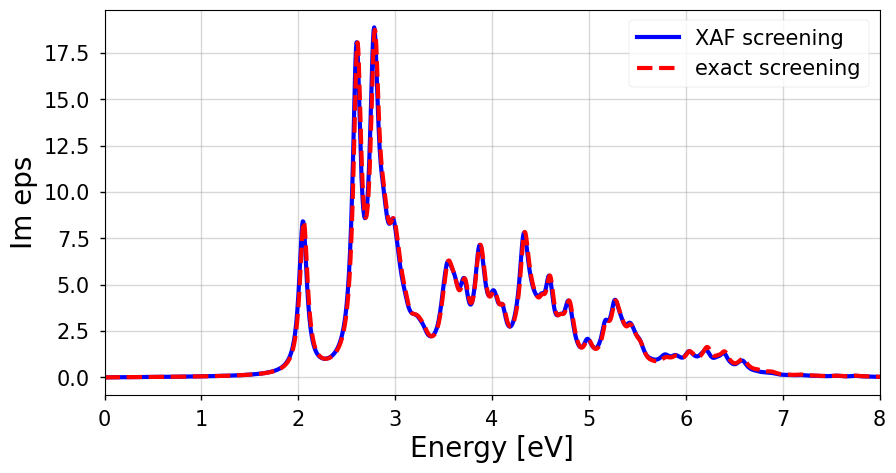

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
from excitingjupyter.utilities import set_plot_parameters


epsilon_xaf = np.genfromtxt('ref/XAF/EPSILON_BSE-singlet-TDA-BAR_SCR-full_OC11.OUT')
epsilon_exact = np.genfromtxt('ref/exact/EPSILON_BSE-singlet-TDA-BAR_SCR-full_OC11.OUT')


set_plot_parameters(figure_width=10, figure_height=5, fontsize=20)
fig, ax =  plt.subplots()
ax.plot(epsilon_xaf[:,0], epsilon_xaf[:,2],label="XAF screening", color="blue")
ax.plot(epsilon_exact[:,0], epsilon_exact[:,2],'--',  label="exact screening", color="red")


ax.set_xlabel('Energy [eV]')
ax.set_ylabel('Im eps')
ax.set_xlim(0,8)
plt.legend()
plt.show()